# Random Forests and Decision Trees

**Author: Ben Fraser**

Throughout this notebook we'll be performing a deep-dive into the Random Forest and Decision tree algorithms for machine learning. We'll do this with a practical focus, whereby we'll be implementing entire Random Forest and Decision Tree models from scratch using nothing but Python and Numpy. 

We'll start by briefly covering the main concepts of random forest and decision trees, in particular the Classification and Regression Tree (CART) algorithm and associated cost functions for making binary splits in decision trees.

Following this we'll use off-the-shelf Random Forest and Decision Tree models from Scikit-Learn to explain some key features of the models themselves, including why they are so useful in practice for data related problems.

Finally, we'll implement entire models from scratch in Python, which we'll then test on a sample dataset ([Fish Market](https://www.kaggle.com/aungpyaeap/fish-market) Dataset from Kaggle).

This notebook supplements the blog article written [here](https://link.medium.com/G0ndMqsUC5), and so I recommend working through these as a pair to get the most out of it. 

In addition, the models created in this notebook were formed using the concepts and frameworks provided in the [FastAI Machine Learning for Coders Course](http://course18.fast.ai/ml), so a large amount of credit is due to Jeremy and the team at FastAI for this.

---

## Contents:

### 1. Importing Dependencies


### 2. Introduction and overview of Random Forest Models


### 3. Decision Tree and Splitting Criteria


### 4. Binary splits and recursion


### 5. Example of why decision trees are good choices compared to linear models


### 6. Example of existing Random Forest model using Scikit-Learn


### 7. Python Implementation of a Random Forest and Decision Tree Model.


### 8. Summary

---

## 1. Import dependencies

For our Custom Random Forest and Decision Tree models we'll rely on minimal external libraries, with exception to Numpy and Pandas. Despite this, there are many concepts and tutorial examples explained in this notebook using external libraries, since these provided the simplest means of doing so.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from matplotlib.colors import ListedColormap
from pydotplus import graph_from_dot_data
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from IPython.display import Image

---

## 2. Introduction and overview of Random Forest Models

A random forest is an ensembling technique, which aggregates a number of individual decision trees to make a more effective overall model. They are without a doubt one of the best models for quickly obtaining a reasonable solution to most structured data problems. They can be adapted to both regression and classification problems, are resistant to over-fitting (with sufficient estimators), and they work without any need for data standardisation or creation of dummy variables. You wont get the best performance with this ensemble technique, however, their simplicity and value in interpreting our data makes them extremely useful.

Tree-based models are also effective at capturing complex relationships between data that linear models would fail miserably at. In addition, they also offer brilliant interpretability and analysis functions to help explain how our models came to a particular result.

Throughout this notebook we'll be exploring some of these features. We'll also built an entire Random Forest and associated Decision Tree model completely from scratch in Python, followed by testing this on a sample dataset. Before getting started however, let's summarise the Random Forest algorithm.


**Random Forest algorithm summarised**

In summary, the process we follow for a random forest is the following:

1. Form n bootstrapped samples from the training data, which are used to train n individual decision trees. A bootstrapped sample is a randomised sample of the original training set with replacement, meaning we have some duplicate training samples (and some samples missing entirely, known as out-of-bag).


2. Grow n decision trees from each bootstrapped sample.


3. During each individual decision tree split, randomly choose a sample of features and select the best split using only those columns. The choice on making this split is based on the objective function used, such as entropy, Gini index, classification error, Mean Squared Error etc.


4. Aggregate our results and form the overall random forest prediction by averaging our results. For regression, this will be the mean taken across all decision trees formed. For classification, this will often be through majority voting. Each individual tree will assign a class label (by majority), and then the overall random forest will chose the final class label across all trees using majority voting.

---

## 3. Decision Tree and Splitting Criteria

The key to forming a random forest model is a decision tree, whereby we combine many of them together to obtain a better overall performance. Individual trees suffer with high variance, but we significantly reduce this and simultaneously increase predictive performance by averaging many trees together.

### 3.1 Information gain, CART and cost functions 

By starting at the tree root, we want to recursively split our data on features that result in the largest information gain. Mathematically, the information gain objective function is:

$ IG(D_{p}, feature) = I(D_{p}) - \sum^{m}_{j=1} \displaystyle\frac{N_{j}}{N_{p}} I(D_{j}) $ 

$ N_{p} $ is the total number of samples at the parent node, $ N_{j} $ is the number of samples at the jth child node. $ D_{p} $ and $ D_{j} $ are the data samples at the parent and jth child nodes respectively. $ I $ is our impurity measure. 

The lower the impurity of the child nodes compared to the parent node, the larger our information gain, which is what we want to maximise. Most decision tree implementations make use of binary splits to minimise computational complexity, which makes our objective function more simplified. This means there are only two child nodes (left and right) for each split:

$ IG(D_{p}, feature) = I(D_{p}) - \displaystyle\frac{N_{left}}{N_{p}} I(D_{j}) - \displaystyle\frac{N_{right}}{N_{p}} I(D_{right})  $

The impurity measure depends highly on whether our model is performing regression or classification.

To implement this into our algorithm, we need it in the form of a cost function that we seek to minimise. The equation above is more commonly referred to as the **Classification and Regression Tree (CART) algorithm** (Géron, 2019, p. 179), which is written in the form of a cost function, $ J $, like so:

$ J(k ,t_{k})) = \displaystyle\frac{m_{left}}{m}G_{left} + \displaystyle\frac{m_{right}}{m}G_{right} $

Where: 
- $ G_{left/right} $ is the impurity (standard deviation in this case) of the left/right splits
- $ m_{left/right} $ is the number of instances in the left/right splits

### 3.2 Decision Tree - Regression

#### Splitting criterion - available options

For splitting with a random forest regressor, a common option is the Mean Squared Error as the impurity measure:

$ I(t) = MSE(t) = \displaystyle\frac{1}{N_{t}} \sum_{i \in D_{t}}(y^{i} - \hat{y}_{t})^{2} $

In this case, we calculate the prediction value, $ \hat{y}_{t} $ for each tree by calculating the mean of output values at the given node t:

$ \hat{y}_{t} = \displaystyle\frac{1}{N_{t}} \sum_{i \in D_{t}} y^{i} $

Another option for regression, if we wanted it, would be the Mean Absolute Error:

$ I(t) = MAE(t) = \displaystyle\frac{1}{N_{t}} \sum_{i \in D_{t}}|y^{i} - \hat{y}_{t}| $


#### Chosen method for this example - standard deviation reduction

Finally, a different option, which shall be used in this decision tree, is standard deviation reduction:

$ I(t) = \sigma(t) = \displaystyle\sqrt{ \frac{\sum{ \Big(y^{i} - \hat{y}_{t} \Big)^{2}}}{N_{t}} } $

The results from applying this criterion to our decision tree should similarly match that of Mean Squared Error.

Conveniently, this equation for standard deviation can be re-arranged into a better form for vectorised calculations in numpy like those we will be using:

$ \sigma(t) = \displaystyle\sqrt{ \frac{\sum{ \Big(y^{i} - \hat{y} \Big)^{2}}}{N_{t}}} $

$ \sigma(t) = \displaystyle\sqrt{ \frac{\sum{ \Big((y^{i})^{2} - 2y^{i}\hat{y} + \hat{y}^{2} \Big)}}{N_{t}}} $

$ \sigma(t) = \displaystyle\sqrt{ \frac{\sum{ \big( (y^{i})^{2} \big) }}{N_{t}} - \frac{2\hat{y}\sum{y^{i}}}{N_{t}} + \frac{N_{t}\hat{y}^{2}}{N_{t}} } $

$ \sigma(t) = \displaystyle\sqrt{ \frac{\sum{ \big( y^{i} \big)^{2} }}{N_{t}} - 2\hat{y}^{2} + \hat{y}^{2} } $

$ \therefore \sigma(t) = \displaystyle\sqrt{ \frac{\sum{ \big( y^{i} \big)^{2} }}{N_{t}} - \hat{y}^{2}} $

Thus, we can determine the standard deviation from simply square rooting the mean sum of squares minus the mean squared. For this calculation, we are just using the formula for a population standard deviation (regardless of whether its a population or sample in this case - the specifics are not important). This will be our impurity criterion for making a binary split using the equations defined above.

In [2]:
def mean_squared_error(y, y_preds):
    return np.square(y - y_preds).mean()

def mean_absolute_error(y, y_preds):
    return np.abs(y - y_preds).mean()

def standard_deviation(n, summed_vals, summed_vals_squared):
    """ Standard deviation using summed vals and sum of squares """
    return np.sqrt((summed_vals_squared / n) - 
                   np.square(summed_vals / n))

### 3.3 Decision Tree - Classification

For a random forest classifier, the algorithm remains almost exactly the same, except that we use different impurity measures and determine the overall predicted class through majority voting. The three common criteria used are Gini Index, Entrpy, and Classification Error. 

Entropy and Gini Index are very similar, and each seek to maximise the mutual information contained in our decision tree. 

#### Gini Index

$ I_{G}(t) = 1 - \sum^{c}_{i=1} p(i/t)^{2} $

We maximise the gini index if we have a perfect split of classes (uniform class distribution), e.g. proportion of 0.5 for two classes.


#### Entropy

$ I_{E}(t) = - \sum^{c}_{i=1} p(i/t)\log_{2}p(i/t) $


#### Classification Error

$ I_{C}(t) = 1 - max \big( p(i/t) \big) $

In [3]:
def gini_index(p):
    """ Gini impurity for binary classification """
    return p*(1-p) + ((1-p)*(1 - (1-p)))

def entropy(p):
    """ Entropy for binary classification """
    return - (p*np.log2(p) + ((1-p)*np.log2(1-p)))

def classification_error(p):
    """ Classification error for binary classification """
    return 1 - np.max([p, 1 - p])

---

## 4. Binary splits and recursion

One of the most complex concepts with producing a decision tree is that of recursion. Our decision tree model will be called many times from within each decision tree model produced. Each tree node performs a binary split (unless it is a leaf), which means each node will create two splits (left and right). Each split will create a new decision tree, and in turn, each new tree will perform further left and right splits with new decision trees. This process repeats until our decision tree is of sufficient depth, which depends on the value of min_leaf or max_depth parameter selected. 

Basically we form many trees within trees for each Random Forest Decision Tree, and this continues until we reach leaf nodes or maximum depth for all left and right splits. The maximum depth and min sample leaf parameters are very important and significantly impacts how our model can under or over-fit the data. We'll explore this further later on.

---

## 5. Example of why decision trees are good choices compared to linear models

Just one of the many useful aspects of a random forest (or any tree-based method in general) is the ability to capture complex relationships between different data types. 

As an example, we'll compare the performance of decision boundaries formed for a basic classification task for both a basic linear classifier (logistic regression) and a basic decision tree. Although this is an extremely simple example, it highlights the flexibility of tree-based methods to train to classify complex relationships that would otherwise be very difficult to capture.

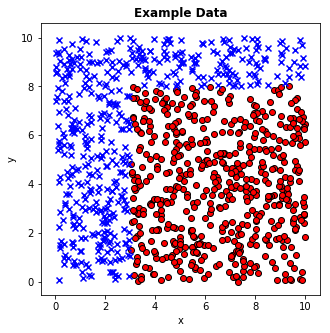

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [4]:
example_data = np.random.rand(1000,2)*10

class_a = example_data[np.where((example_data[:, 0] > 3) & (example_data[:, 1] < 8))]
class_b = example_data[np.where((example_data[:, 0] <= 3) | (example_data[:, 1] >= 8))]

X = np.concatenate([class_a, class_b])
y = np.concatenate([np.zeros(class_a.shape[0]), np.ones(class_b.shape[0])])

plt.figure(figsize=(5,5))
plt.scatter(class_a[:, 0], class_a[:, 1], label='Class A', 
            marker='o', color='red', edgecolor='black')
plt.scatter(class_b[:, 0], class_b[:, 1], label='Class B', 
            marker='x', color='blue', edgecolor='black')
plt.xlabel("x")
plt.ylabel('y')
plt.title("Example Data", weight='bold')
plt.show()


decision_tree = DecisionTreeClassifier()
logreg_model = LogisticRegression(solver='lbfgs')

decision_tree.fit(X, y)
logreg_model.fit(X, y)

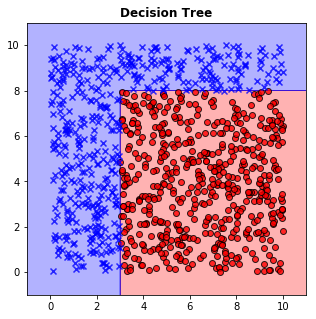

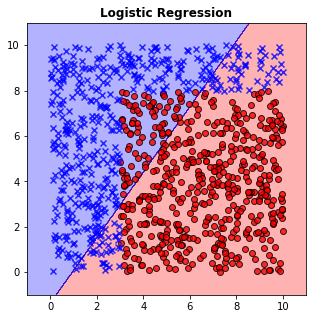

In [5]:
def plot_boundaries(X, y, clf, resolution=0.02, figsize=(5,5), title='Decision Boundary'):
    """ Plot basic decision boundaries for given classifier and 
        X and y data """
    
    plt.figure(figsize=figsize)
    
    markers = ('o', 'x', 's', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    Z = clf.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.xlim(xx2.min(), xx2.max())
    
    plt.title(title, weight='bold')
    
    for idx, class_example in enumerate(np.unique(y)):
        plt.scatter(x=X[y == class_example, 0], y=X[y == class_example, 1],
                   alpha=0.8, c=colors[idx], marker=markers[idx],
                   label=class_example, edgecolor='black')
        
plot_boundaries(X, y, decision_tree, title="Decision Tree")
plot_boundaries(X, y, logreg_model, title="Logistic Regression")

We can see that the linear model fails to effectively capture the non-linear decision boundary, whilst the decision tree model performs exceptionally. 

In addition to this, we can easily explain how our decision model came to this conclusion by drawing the actual decision tree, like so:

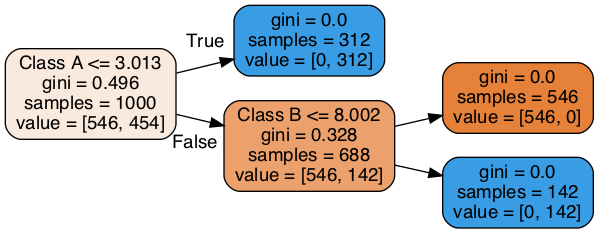

In [6]:
def show_tree_graph(tree_model, feature_names):
    """ Output a decision tree to notebook """
    draw_data = export_graphviz(tree_model, filled=True, 
                                rounded=True, feature_names=feature_names, 
                                out_file=None, rotate=True)
    graph = graph_from_dot_data(draw_data)

    return Image(graph.create_png())

cols = ['Class A', 'Class B']
show_tree_graph(decision_tree, feature_names=cols)

Thus, this diagram of our decision tree very effectively explains how our model discriminated between each of the classes. The benefit of this type of analysis is that we can use decision trees to explain model decisions even to non-technical personnel with relative ease.

---

## 6. Example of existing Random Forest model using Scikit-Learn

#### Sample dataset for this notebook: Fish Market dataset

We'll start by importing the dataset and inspecting the layout prior to further processing.

In [7]:
np.random.seed(12)

In [8]:
fish_df = pd.read_csv('Fish.csv')
fish_df.head(5)

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


There are many things we could do with this data as it stands:

1. We could perform regression in order to predict the weight of a fish given its features.


2. We could perform classification in order to predict the fish species.

For this analysis we'll choose the former - performing regression on fish weights.

With this in mind, lets form our training data, X, and our output labels, y:

In [9]:
y = fish_df['Weight'].values
X = fish_df.drop('Weight', axis=1)

Now, let's inspect how many of each type of fish we have before going further:

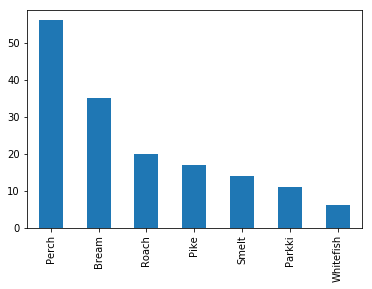

In [10]:
X['Species'].value_counts().plot.bar()
plt.show()

Unfortunately, we dont have many Whitefish or Parkki. However, for this example it will suffice.

As you might have noticed, the species column is the only categorical data type we have in the dataframe. In order to effectively use this feature column within our machine learning models, we need to convert the categorical strings into a numerical form. We call this label encoding, and it can be done either manually or using premade models, such as scikit-learns LabelEncoder class.

We'll quickly convert this categorical data into numerical encoded data using a LabelEncoder, like so:

In [11]:
encoder = LabelEncoder()
encoder.fit(X['Species'])
encoder.classes_

array(['Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish'],
      dtype=object)

In [12]:
X['Species'] = encoder.transform(X['Species'])
X['Species'].value_counts()

2    56
0    35
4    20
3    17
5    14
1    11
6     6
Name: Species, dtype: int64

Great, we now see that our previous strings are now represented as integers, ranging from 0 - 6.

Following this, we could also one-hot encode these features, which would be a wise choice if we were using neural networks. However, with Random Forests and Decision trees its debatable as to whether we should one-hot encode our features. Certain studies have found that performance can remain higher in many tasks when using just regular encoded values rather than one-hot encoded features, but we'll leave this for another time - for this example we'll just use the normal encodings shown above.

Lets now split our training data into training and test partitions. Normally, we would have a total of three data splits: training, validation and testing. Training sets are used to train our models, whilst validations are used to assess the model performance and tune our hyper-parameters. The test set is generally held-out completely until the very end, at which point we test the final generalisation performance of our model.

In this example we'll just create a training and test split to keep things simple:

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    stratify=X['Species'], random_state=7)

print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

X_train shape: (119, 6), X_test shape: (40, 6)


Lets train a pre-made random forest model from sklearn on our data and visualise some features specific to our model.

In [14]:
rf_regr = RandomForestRegressor(n_estimators=2, max_depth=3)
rf_regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

A key feature of Random Forest models is the ability to ability to compute feature importances. We can grade this feature importance in multiple ways. The popular way (used by Scikit-Learn) is to measure how much a feature reduces the impurity on average across all trees in the forest. For our model, this would equate to measuring on average how strongly each feature reduces the cost function across all our tree models.

In [15]:
def feature_importances(rf_model, dataframe):
    return pd.DataFrame({'columns' : dataframe.columns, 
                         'importance' : rf_model.feature_importances_}
                       ).sort_values('importance', ascending=False)

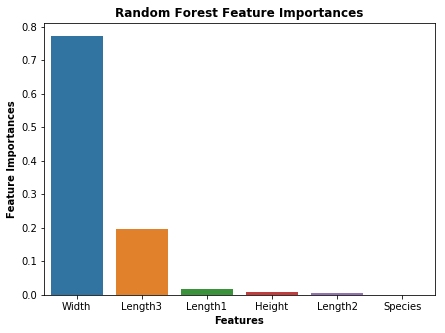

   columns  importance
5    Width    0.771866
3  Length3    0.196253
1  Length1    0.017961
4   Height    0.008512
2  Length2    0.005407
0  Species    0.000000


In [16]:
importances = feature_importances(rf_regr, X_train)

plt.figure(figsize=(7,5))
sns.barplot(x="columns", y="importance", data=importances)
plt.ylabel("Feature Importances", weight='bold')
plt.xlabel("Features", weight='bold')
plt.title("Random Forest Feature Importances", weight='bold')
plt.show()
print(importances)

Another way to calculate feature importances is to randomly shuffle each feature column and measure how much it impacts the evaluation score. This is done after training of a model on the dataset, and is performed on each feature one at a time in order to compare how much it reduces (or even improves) the evaluated score. Those features that cause the largest drop represent the most important, whilst those that have minimal impact are the least important. 

We'll implement this type of feature importance in our custom Random Forest model further below.

#### Further exploration of the fish market dataset

With our feature importances visualised above, lets briefly explore the fish market dataset further. We saw that the width is the most important feature, and so lets plot this against our dependent variable, weight. We'll also include some other features using seaborns built-in features, such as species and Length3 (second most important feature).

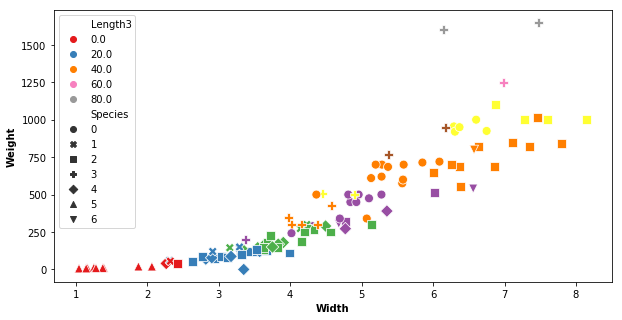

In [17]:
cmap = sns.cubehelix_palette(dark=.1, light=.7, as_cmap=True)
plt.figure(figsize=(10,5))
sns.scatterplot(x=X_train['Width'], y=y_train, data=X_train, 
                hue='Length3', s=80, palette="Set1", style='Species')
plt.xlabel("Width", weight='bold')
plt.ylabel("Weight", weight='bold')
plt.show()

Lets compare the relationships between the dependent variable and the width and Length3 features:

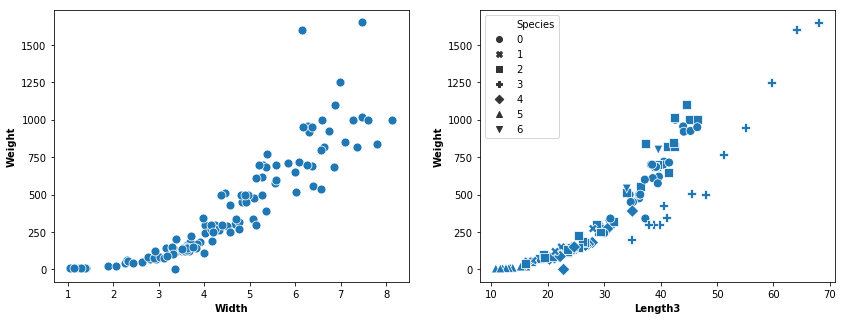

In [18]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_train['Width'], y=y_train, data=X_train, s=80)
plt.xlabel("Width", weight='bold')
plt.ylabel("Weight", weight='bold')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_train['Length3'], y=y_train, data=X_train, s=80, style='Species')
plt.xlabel("Length3", weight='bold')
plt.ylabel("Weight", weight='bold')
plt.show()

Out of curiosity, lets see what the relationship between the dependent variable, Weight, and product of the two most important features (Width x Length3). We'll also look at the effect of log transforming the Weight:

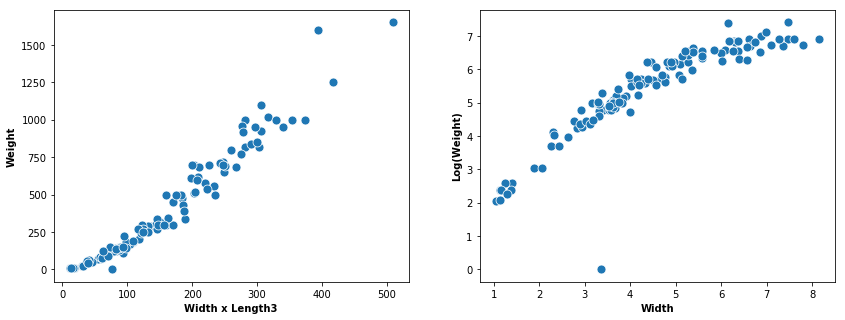

In [19]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_train['Width']*X_train['Length3'], y=y_train, data=X_train, s=80)
plt.xlabel(f"Width x Length3", weight='bold')
plt.ylabel("Weight", weight='bold')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_train['Width'], y=np.log1p(y_train), data=X_train, s=80)
plt.xlabel("Width", weight='bold')
plt.ylabel("Log(Weight)", weight='bold')
plt.show()

It appears we can obtain a very good linear fit through multiplication of the top two important features: Width and Length3. As seen above, we can also obtain a slightly better fit through log transforming our dependent variable, Weight.

Without applying any of these transformations, lets inspect how well a Random Forest can fit to our total data, X, just out of interest:

In [20]:
def plot_tree_regression(X, y, x_axis, model, figsize=(6,4)):
    """ Helper function to plot data and regression line """
    X_ = X[x_axis] # indexes of sorted X vals
    sort_idx = X_.values.flatten().argsort()
    
    plt.figure(figsize=figsize)
    plt.scatter(x=X[x_axis], y=y, color='tab:blue', edgecolor='white', s=70)
    
    plt.step(X_.iloc[sort_idx], model.predict(X.iloc[sort_idx, :]), 
             color='tab:red', lw=2, alpha=0.8)
    return None

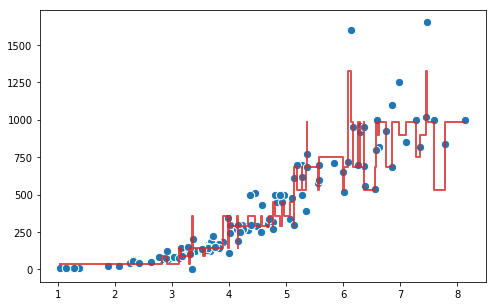

In [21]:
plot_tree_regression(X_train, y_train, x_axis='Width', model=rf_regr, figsize=(8,5))

#### Illustration of n_estimators hyper-parameter (number of individual decision trees for ensemble)

To help understand how a Random Forest is almost always a better solution than an individual decision tree, lets see the impact of model fitment when we combine many individual decision trees together (to form a Bagging / Random Forest model).

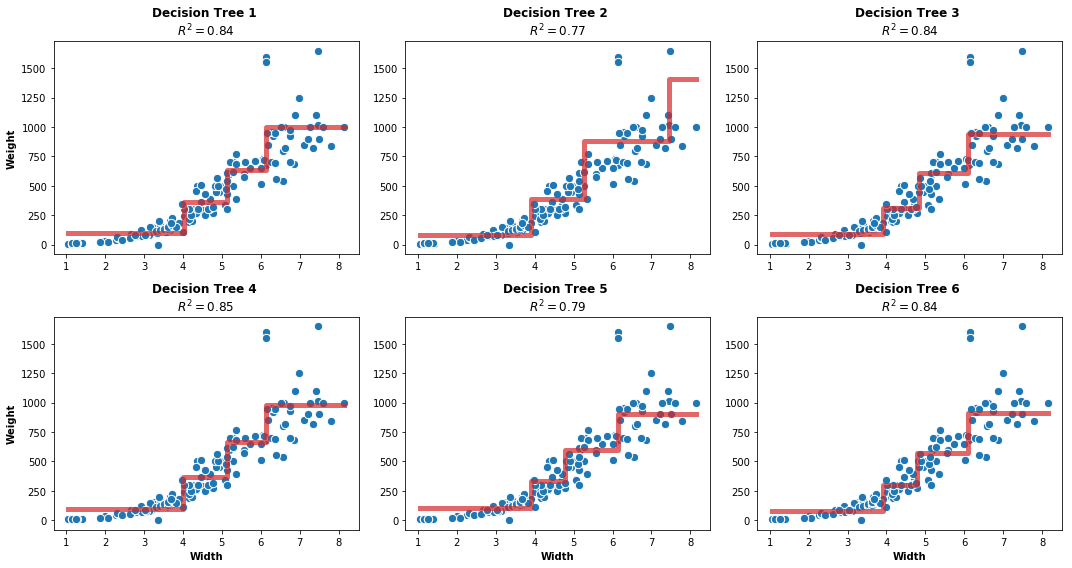

In [22]:
X_subset = X['Width'].values.reshape(-1, 1)

rf_model = RandomForestRegressor(max_depth=2, n_estimators=10).fit(X_subset, y)

plt.figure(figsize=(15, 8))
sort_idx = X_subset.flatten().argsort()

for i in range(0, 6):
    
    decision_tree = rf_model.estimators_[i]
    preds = decision_tree.predict(X_subset[sort_idx])
    r2 = r2_score(y[sort_idx], preds)
    mse = mean_squared_error(y[sort_idx], preds)
    
    ax = plt.subplot(2, 3, i + 1)
    ax.set_title(f"Decision Tree {i + 1} \n$R^{2} = {r2:.2f}$", weight='bold')
    ax.scatter(x=X_subset, y=y, color='tab:blue', edgecolor='white', s=70)
    ax.step(X_subset[sort_idx], preds, color='tab:red', lw=5, alpha=0.7)
    
    if i == 0 or i == 3:
        ax.set_ylabel("Weight", weight='bold')
    
    if i > 2:
        ax.set_xlabel("Width", weight='bold')
    
plt.tight_layout()
plt.show()

Above we can see six individual decision trees, which were formed as part of the Random Forest model. Individually, they have a mixture of performances, some bad and some good. If we combine the results of all these models together, we obtain our overall Random Forest regression line, which is shown below:

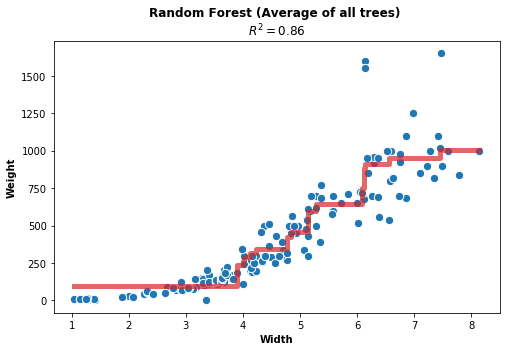

In [23]:
preds = rf_model.predict(X_subset[sort_idx])
r2 = r2_score(y[sort_idx], preds)
mse = mean_squared_error(y[sort_idx], preds)

plt.figure(figsize=(8,5))
plt.scatter(x=X_subset, y=y, color='tab:blue', edgecolor='white', s=70)
plt.step(X_subset[sort_idx], preds, color='tab:red', lw=5, alpha=0.7)
plt.title(f"Random Forest (Average of all trees) \n$R^{2} = {r2:.2f}$", weight='bold')
plt.ylabel("Weight", weight='bold')
plt.xlabel("Width", weight='bold')
plt.show()

As shown, the overall performance of the Random Forest regression line is a better-fitting, higher-performing model. Notice that our $ R^{2} $ for the Random Forest is also higher than any of the individual decision tree models, as expected. 

#### Illustration of max depth hyper-parameter

The ability of our decision trees in fitting to the data depends on the value of maximum depth chosen. Extreme values of this can cause over-fitting to our training data, whilst too low a value will fail to capture enough information in the data to effectively make predictions.

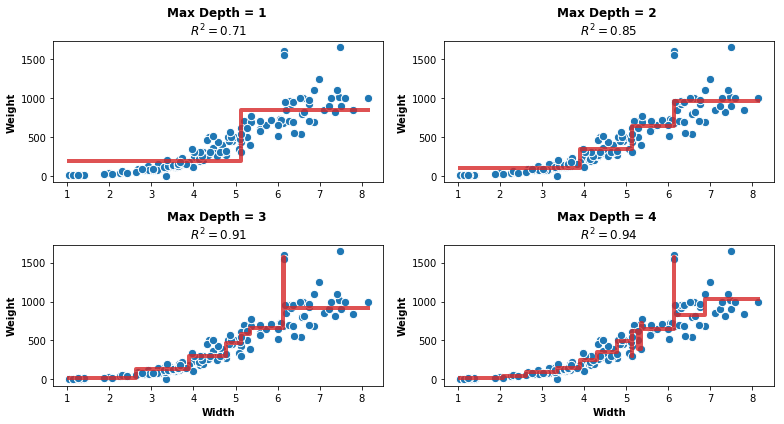

In [24]:
X_subset = X['Width'].values.reshape(-1, 1)
sort_idx = X_subset.flatten().argsort()

plt.figure(figsize=(11, 6))

for i in range(1, 5):
    
    tree_model = DecisionTreeRegressor(max_depth=i).fit(X_subset, y)
    preds = tree_model.predict(X_subset[sort_idx])
    r2 = r2_score(y[sort_idx], preds)
    
    plt.subplot(2, 2, i)
    plt.scatter(x=X_subset, y=y, color='tab:blue', edgecolor='white', s=70)
    plt.step(X_subset[sort_idx], preds, 
             color='tab:red', lw=4, alpha=0.8)
    plt.title(f"Max Depth = {i} \n$R^{2} = {r2:.2f}$", weight='bold')
    plt.ylabel("Weight", weight='bold')
    
    if i > 2:
        plt.xlabel("Width", weight='bold')
        
plt.tight_layout()
plt.show()

Now that we've performed some basic analysis of a random forest regressor on the sample dataset, lets dig into customised Python models from scratch for both a Random Forest and Decision Tree.

---

## 7. Python Implementation of a Random Forest and Decision Tree Model

In [25]:
class RandomForest():
    """ Python implementation of a random forest regressor """
    def __init__(self, x, y, num_trees, sample_size, feature_proportion=1.0, 
                 min_leaf=5, bootstrap=False, random_seed=12):
        np.random.seed(random_seed)
        self.x = x
        self.y = y
        self.num_trees = num_trees
        self.sample_size = sample_size
        self.feature_proportion = feature_proportion
        self.min_leaf = min_leaf
        self.bootstrap = bootstrap
        self.trees = [self.create_tree(bootstrap) for i in range(num_trees)]
    
    
    def create_tree(self, bootstrap=False):
        """ Form individual decision tree """
        
        # obtain a random sample of indices and identify oob samples
        idxs = np.random.permutation(self.y.shape[0])[:self.sample_size]
        
        oob_idxs = None
        
        # if bootstrap chosen get bootstrap sample and oob indexes
        if bootstrap:
            idxs, oob_idxs = self.bootstrap_samples(idxs)
        
        return DecisionTree(self.x.iloc[idxs], self.y[idxs], 
                            feat_proportion=self.feature_proportion, 
                            idxs=np.array(range(self.sample_size)), 
                            oob_idxs=oob_idxs, 
                            min_leaf=self.min_leaf)
    
    
    def predict(self, x):
        """ Return the mean of predictions across trees """
        # call predict function from each Tree class
        return np.mean([t.predict(x) for t in self.trees], axis=0)
    
    
    def oob_score(self):
        """ Calculate and return each tree OOB R2 score and the average 
            OOB score across all decision trees """
        
        tree_oob_scores = []
        
        # find oob score for each tree and append to results
        for tree in self.trees:
            
            # find current tree oob predictions and labels
            tree_oob_labels = self.y[tree.oob_idxs]
            tree_oob_preds = tree.predict(self.x.iloc[tree.oob_idxs].values)
            
            # calculate R2 score for predictions on current tree
            tree_oob_r2 = r2_score(tree_oob_labels, tree_oob_preds)
            
            # add R2 score for oob predictions from this tree
            tree_oob_scores.append(tree_oob_r2)
        
        tree_oob_scores = np.array(tree_oob_scores)
        
        # find average oob scores across all trees
        avg_oob_score = np.mean(tree_oob_scores)
    
        return tree_oob_scores, avg_oob_score
    
    
    def bootstrap_samples(self, idxs):
        """ Return bootstrapped sample indices based on y and sample size """
        
        # take sample (with replacement) of idxs and set as bootstrap sample
        sample_idxs = np.random.randint(0, len(idxs), size=self.sample_size)
        bootstrap_idxs = idxs[sample_idxs]
        
        # find out-of-bag (OOB) samples from the passed idxs array
        i = np.arange(self.sample_size)
        oob_i = np.array([ind for ind in i if ind not in sample_idxs])
        oob_idxs = idxs[oob_i]
        
        return bootstrap_idxs, oob_idxs
    
    
    def feature_importances(self):
        """ Find the feature importances by shuffling each feature
            and finding the drop in score relative to baseline. """
        
        # find baseline r2 score - all features will compare against this
        baseline_score = r2_score(self.y, self.predict(self.x.values))
        
        # dictionary to store feature importances
        feat_importances = {}
        columns = self.x.columns
        
        # iterate through each column, shuffle and get new score
        for feat_column in columns:
            
            # shuffle only current column
            temp_df = self.x.copy()
            feat_vals = temp_df[feat_column].values
            np.random.shuffle(feat_vals)
            
            # find new R2 score with shuffled feature
            shuffled_score = r2_score(self.y, self.predict(temp_df.values))
            
            # calculate how much score has changed - this represents importance
            feat_score = (baseline_score - shuffled_score) / baseline_score
            
            # add to importance dict
            feat_importances[feat_column] = feat_score
        
        importance_df = pd.DataFrame.from_dict(feat_importances, 
                                               orient='index',
                                               columns=['Importance'])
        
        return importance_df.sort_values('Importance', ascending=False)

In [26]:
class DecisionTree():
    """ Form a basic decision tree """
    def __init__(self, x, y, idxs=None, oob_idxs=None, 
                 min_leaf=5, feat_proportion=1.0):
        if idxs is None:
            idxs = np.arange(len(y))
        self.x = x
        self.y = y
        self.idxs = idxs
        self.oob_idxs = oob_idxs
        self.min_leaf = min_leaf
        self.feat_proportion = feat_proportion
        self.rows = len(idxs)
        self.cols = self.x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.binary_split()
    
    
    def __repr__(self):
        """ String reputation of our decision tree """
        text = f'n: {self.rows}, val: {self.val}'
        if not self.is_leaf:
            text += f', score: {self.score}, split: {self.split}, var: {self.split_name}'
        return text
    
    
    def binary_split(self):
        """ find best feature and level to split at to produce greatest
            reduction in variance """
        
        # randomly select sub-sample of features
        num_feat = int(np.ceil(self.cols*self.feat_proportion))
        col_idxs = range(self.cols)
        feature_subset = np.random.permutation(col_idxs)[:num_feat]
        
        # iteratively split each col and find best
        for i in feature_subset:
            self.best_binary_split(i)
        # if leaf node stop
        if self.score == float('inf'):
            return
        
        # get split col and idxs for lhs and rhs splits
        x = self.split_col_values
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        
        # create new decision trees for each split
        self.left_split = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.right_split = DecisionTree(self.x, self.y, self.idxs[rhs])
            
            
    def best_binary_split(self, feat_idx):
        """ Find best binary split for the given feature """
        x = self.x.values[self.idxs, feat_idx]
        y = self.y[self.idxs]
        
        # sort our data
        sorted_ind = np.argsort(x)
        sorted_x = x[sorted_ind]
        sorted_y = y[sorted_ind]
        
        # get count, sum and square sum of lhs and rhs
        lhs_count = 0
        rhs_count = self.rows
        lhs_sum = 0.0
        rhs_sum = sorted_y.sum()
        lhs_sum2 = 0.0
        rhs_sum2 = np.square(sorted_y).sum()
        
        # iterate through all values of selected feature - eval score
        for i in range(0, self.rows - self.min_leaf):
            x_i = sorted_x[i]
            y_i = sorted_y[i]
            
            # update count and sums
            lhs_count += 1
            rhs_count -= 1   
            lhs_sum += y_i
            rhs_sum -= y_i
            lhs_sum2 += y_i**2
            rhs_sum2 -= y_i**2
            
            # if less than min leaf or dup value - skip
            if i < self.min_leaf - 1 or x_i == sorted_x[i + 1]:
                continue
            
            # find standard deviations of left and right sides
            lhs_std = self.standard_deviation(lhs_count, lhs_sum, lhs_sum2)
            rhs_std = self.standard_deviation(rhs_count, rhs_sum, rhs_sum2)
            
            # find weighted score
            current_score = (lhs_count*lhs_std) + (rhs_count*rhs_std)
            
            # if score lower (better) than previous, update
            if current_score < self.score:
                self.feat_idx = feat_idx
                self.score = current_score
                self.split = x_i
    
    
    def standard_deviation(self, n, summed_vals, summed_vals_squared):
        """ Standard deviation using summed vals, sum of squares, and data size """
        return np.sqrt((summed_vals_squared / n) - np.square(summed_vals / n))
    
    
    def predict(self, x):
        """ Find and return predictions for all the samples in x """
        return np.array([self.predict_sample(x_i) for x_i in x])
    
    
    def predict_sample(self, x_i):
        """ Take a sample x_i and return the predicted value using recursion """
        # if leaf node - return mean value
        if self.is_leaf:
            return self.val
        
        # if value less than tree split value lhs, else rhs
        elif x_i[self.feat_idx] <= self.split:
            tree = self.left_split
        else:
            tree = self.right_split
            
        # recursively continue through the tree with x_i until leaf node
        return tree.predict_sample(x_i)
    
    
    @property
    def split_name(self):
        """ return name of column we are splitting on """
        return self.x.columns[self.feat_idx]
    
    
    @property
    def split_col_values(self):
        """ return values of column we have split on """
        return self.x.values[self.idxs, self.feat_idx]
    
    
    @property
    def is_leaf(self):
        """ If leaf node, score will be infinity """
        return self.score == float('inf')

### Import data and test model

Now that we've completely formed our models, lets test their functionality on the Fish Market dataset.

Lets start by forming a Random Forest model with 10 estimators (individual decision trees). To start, we'll select all features (bagging model), and enable Bootstrap sampling.

In [27]:
random_forest = RandomForest(X_train, y_train, 10, X_train.shape[0], feature_proportion=1.0, bootstrap=True)
tree = random_forest.trees[0]
x_data, y_data = tree.x, tree.y
x_data.columns

Index(['Species', 'Length1', 'Length2', 'Length3', 'Height', 'Width'], dtype='object')

In [28]:
tree

n: 119, val: 394.4336134453781, score: 24450.434547690907, split: 5.1373, var: Width

We can see in this instance that our first tree split on the Width variable at a value of 5.1373.

Lets ensure that our Out of Bag Score functionality works:

In [29]:
tree_oob_scores, avg_oob_score = random_forest.oob_score()
print(f"OOB R2 Score: {avg_oob_score}")

OOB R2 Score: 0.8386962810757419


Our OOB $ R^{2} $ score seems reasonable. We can see that this is the average of the ten OOB scores, as shown below:

In [30]:
tree_oob_scores

array([0.69400157, 0.87241646, 0.92660578, 0.735554  , 0.87689764,
       0.93903717, 0.8472179 , 0.74449777, 0.8475923 , 0.90314221])

In [31]:
np.mean(tree_oob_scores)

0.8386962810757419

Lets also test our feature importances functionality:

In [32]:
feature_importances = random_forest.feature_importances()
feature_importances

,Importance
Width,0.547489
Length3,0.323923
Length2,0.054163
Length1,0.005636
Height,0.004874
Species,0.003822


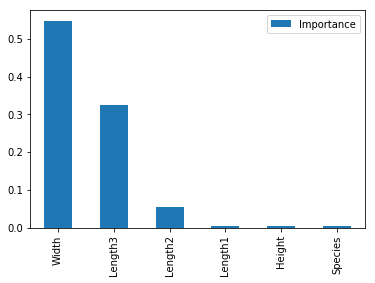

In [33]:
feature_importances.plot.bar()
plt.show()

Good, it appears the Width and Length3 features are by far the most important, which aligns with the results found above using the Scikit-learn feature importances. Should we want to simplify our regression process and remove lower importance features, this functionality could come in handy.

Lets now form a Random Forest model using Scikit learn and output some basic functions on our dataset for comparison, such as tree graphs of splits and the OOB score:

In [34]:
def show_tree_graph(tree_model, feature_names):
    """ Output a decision tree to notebook """
    draw_data = export_graphviz(tree_model, filled=True, 
                                rounded=True, feature_names=feature_names, 
                                out_file=None, rotate=True)
    graph = graph_from_dot_data(draw_data)

    return Image(graph.create_png())

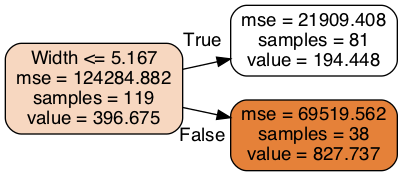

In [35]:
m = RandomForestRegressor(n_estimators=1, max_depth=1, min_samples_leaf=3, bootstrap=False)
m.fit(X_train, y_train)

cols = X_train.columns.values

show_tree_graph(m.estimators_[0], feature_names=cols)

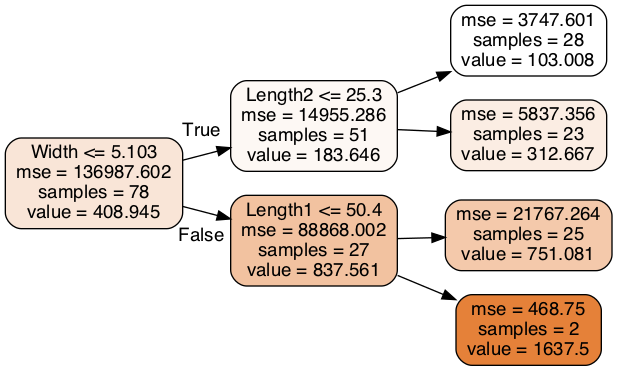

In [36]:
m = RandomForestRegressor(n_estimators=10, max_depth=2, bootstrap=True, oob_score=True)
m.fit(X_train, y_train)

show_tree_graph(m.estimators_[0], feature_names=cols)

In [37]:
m.oob_score_

0.8531632959831972

The OOB score is very close to that obtained using our model, which is a good sign.

Lets now create one of our custom Random Forest models, but this time use only a proportion of features at each decision tree binary split, which is how a legitimate random forest should function:

In [38]:
randf = RandomForest(X_train, y_train, 10, X_train.shape[0], feature_proportion=0.75, bootstrap=True)
tree = randf.trees[0]

Lets see what our first tree split on this time:

In [39]:
tree

n: 119, val: 394.4336134453781, score: 24450.434547690907, split: 5.1373, var: Width

Again, this tree split on Width, which is no surprise with it being the most important feature. However, due to the proportion argument of 0.75, there should be some occasions now where 'Width' is not used as a feature for making a binary split. Statistically, some of our 10 decision trees in our model should have split on a different feature due to this:

In [40]:
for individual_tree in randf.trees:
    print(individual_tree)

n: 119, val: 394.4336134453781, score: 24450.434547690907, split: 5.1373, var: Width
n: 119, val: 399.92352941176466, score: 20659.294598806824, split: 4.7716, var: Width
n: 119, val: 382.5781512605042, score: 23214.765763904907, split: 31.6, var: Length3
n: 119, val: 418.79999999999995, score: 22205.976772075788, split: 5.0728, var: Width
n: 119, val: 410.89663865546214, score: 20646.673905690786, split: 4.2485, var: Width
n: 119, val: 410.8352941176471, score: 21206.264918501136, split: 5.1373, var: Width
n: 119, val: 375.8529411764706, score: 19881.557188450806, split: 5.0728, var: Width
n: 119, val: 381.52436974789913, score: 18939.855096186813, split: 5.1042, var: Width
n: 119, val: 325.80504201680674, score: 16488.87832449221, split: 31.6, var: Length3
n: 119, val: 377.1773109243697, score: 17722.49036128305, split: 28.0, var: Length2


As we can see above, some of the trees split on the Length3 and Length2 features - this will have been due to the Width feature being missed from the random subset of features in this instance.

Although these features give lower scores in general, this feature of random forests is very important since it significantly decorrelates trees within the model. This decorrelation generally leads to an improved generalisation performance and effectiveness of our overall random forest model.

Lets now obtain predictions for both our custom model and scikit learn models, and compare them both visually.

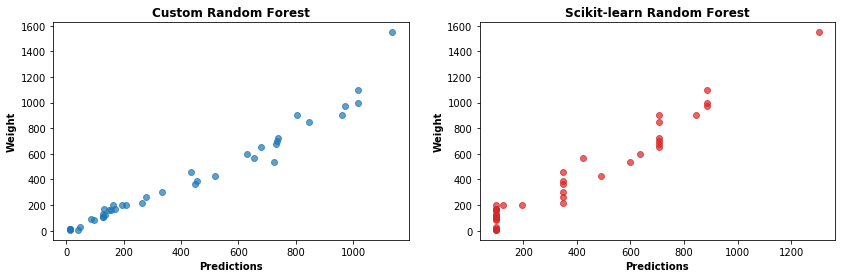

In [41]:
# obtain predictions from custom model and scikit learn
preds = randf.predict(X_test.values)
sklearn_preds = m.predict(X_test)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.title("Custom Random Forest", weight='bold')
plt.xlabel("Predictions", weight='bold')
plt.ylabel("Weight", weight='bold')
plt.scatter(preds, y_test, alpha=0.7, color='tab:blue')

plt.subplot(1, 2, 2)
sklearn_preds = m.predict(X_test)
plt.scatter(sklearn_preds, y_test, alpha=0.7, color='tab:red')
plt.title("Scikit-learn Random Forest", weight='bold')
plt.xlabel("Predictions", weight='bold')
plt.ylabel("Weight", weight='bold')
plt.show()

In [42]:
print(f"R^2 Score for custom model on the test set: {r2_score(preds, y_test)}")
print(f"R^2 Score for Scikit-Learn model on the test set: {r2_score(sklearn_preds, y_test)}")

R^2 Score for custom model on the test set: 0.943384680508587
R^2 Score for Scikit-Learn model on the test set: 0.9162149523169357


Our custom model actually scores higher in this case on the test set - good result! Overall, the custom model is not bad, and possesses many of the important characteristics of a random forest model.

## 8. Summary

As we've seen in this article, even though Random Forests and Decision Trees are conceptually straightforward, they're still difficult to explain with a full code implementation and walkthrough of the major points. Although this model is by no means a replacement of a professional Random Forest model, it should serve as a useful one for learning purposes. I've no doubt there's many underlying inefficiencies and use-case issues with our models, but for gaining an understanding of Random Forests it should be sufficient!


Hopefully you've enjoyed this content, and in the process managed to learn or revise the key concepts. Just like neural networks and other machine learning algorithms, you should never have to actually implement a Random Forest or Decision Tree from scratch. Nevertheless, a solid understanding of the underlying concepts helps massively with using these tools in practice, and more importantly it helps you gain the skills to interpret and tune the hyper-parameters to best suit your own projects.


If you haven't seen it already, this notebook is a working reference to the Article 'A pragmatic dive into Random Forests and Decision Trees with Python' available [here](https://link.medium.com/G0ndMqsUC5). Please check it out if you haven't done so already!